In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.filters.hp_filter import hpfilter

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Layer, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import random
import tensorflow as tf
import time

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/PLN_Timeseries/aa_442400146024_engineered.csv')
# buat df baru hanya READ_DATE dan KWH_EXP saja
df = df[['READ_DATE', 'KWH_EXP', 'tavg', 'tmin', 'tmax', 'wdir', 'wspd', 'pres', 'Tavg', 'RH_avg', 'RR', 'ss']]
df.set_index('READ_DATE', inplace=True)
df

,KWH_EXP,tavg,tmin,tmax,wdir,wspd,pres,Tavg,RH_avg,RR,ss
READ_DATE,,,,,,,,,,,
2019-01-01,0.000000,25.7,24.8,30.2,44.0,6.4,1008.9,25.7,96.0,12.9,7.5
2019-01-02,0.076469,26.0,24.1,29.2,21.0,5.4,1009.2,25.9,90.0,42.7,6.7
2019-01-03,0.310542,24.6,24.0,27.3,340.0,4.1,1010.3,24.9,94.0,0.5,0.1
2019-01-04,0.066232,26.2,23.0,29.8,340.0,6.9,1011.4,25.8,88.0,34.6,0.1
2019-01-05,1.070875,26.9,23.6,30.2,284.0,6.3,1011.7,26.7,88.0,2.1,3.2
...,...,...,...,...,...,...,...,...,...,...,...
2024-05-27,39.352355,28.3,24.4,34.0,126.0,9.9,1009.9,28.7,73.0,0.0,10.4
2024-05-28,36.329893,28.2,24.1,33.9,125.0,8.0,1009.4,28.2,75.0,0.0,8.2
2024-05-29,43.653419,29.0,24.2,33.0,130.0,7.7,1009.1,29.0,77.0,0.0,10.7


In [6]:
lambda_daily_365 = 1600 * (365 / 4) ** 4  # Hasil: sekitar 69.3 x 10^9
print(lambda_daily_365)
# decompose menggunakan hpfilter
cycle, trend = hpfilter(df['tavg'], lamb=lambda_daily_365)
df['trend_tavg'] = trend
df['cycle_tavg'] = cycle
cycle, trend = hpfilter(df['tmin'], lamb=lambda_daily_365)
df['trend_tmin'] = trend
df['cycle_tmin'] = cycle
cycle, trend = hpfilter(df['tmax'], lamb=lambda_daily_365)
df['trend_tmax'] = trend
df['cycle_tmax'] = cycle
cycle, trend = hpfilter(df['wdir'], lamb=lambda_daily_365)
df['trend_wdir'] = trend
df['cycle_wdir'] = cycle
cycle, trend = hpfilter(df['wspd'], lamb=lambda_daily_365)
df['trend_wspd'] = trend
df['cycle_wspd'] = cycle
cycle, trend = hpfilter(df['pres'], lamb=lambda_daily_365)
df['trend_pres'] = trend
df['cycle_pres'] = cycle
cycle, trend = hpfilter(df['Tavg'], lamb=lambda_daily_365)
df['trend_Tavg'] = trend
df['cycle_Tavg'] = cycle
cycle, trend = hpfilter(df['RH_avg'], lamb=lambda_daily_365)
df['trend_RH_avg'] = trend
df['cycle_RH_avg'] = cycle
cycle, trend = hpfilter(df['RR'], lamb=lambda_daily_365)
df['trend_RR'] = trend
df['cycle_RR'] = cycle
cycle, trend = hpfilter(df['ss'], lamb=lambda_daily_365)
df['trend_ss'] = trend
df['cycle_ss'] = cycle

110930628906.25


In [9]:
df.drop(['tavg', 'tmin', 'tmax', 'wdir', 'wspd', 'pres', 'Tavg', 'RH_avg', 'RR', 'ss'], axis=1, inplace=True)

In [11]:
# split data train dan test. 3 tahun pertama untuk train, 2 tahun terakhir untuk test
"""
READ_DATE KWH_EXP	tavg	tmin	tmax	wdir	wspd	pres	Tavg	RH_avg	RR	ss
019-01-01	1.704497	25.7	24.8	30.2	44.0	6.4	1008.9	25.7	96.0	12.9	7.5
2019-01-02	1.804380	26.0	24.1	29.2	21.0	5.4	1009.2	25.9	90.0	42.7	6.7
2019-01-03	1.606232	24.6	24.0	27.3	340.0	4.1	1010.3	24.9	94.0	0.5	0.1
2019-01-04	1.220510	26.2	23.0	29.8	340.0	6.9	1011.4	25.8	88.0	34.6	0.1
2019-01-05	0.980424	26.9	23.6	30.2	284.0	6.3	1011.7	26.7	88.0	2.1	3.2
"""


train = df.loc['2019-01-01':'2022-12-31']
test = df.loc['2023-01-01':'2024-05-24']
real_sim = df.loc['2024-05-25':'2024-05-31']

In [12]:
# Scale data
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

# train_scaled_features = feature_scaler.fit_transform(train)
# train_scaled_target = target_scaler.fit_transform(train[['KWH_EXP_MA']])
# test_scaled_features = feature_scaler.transform(test)
# test_scaled_target = target_scaler.transform(test[['KWH_EXP_MA']])

train_scaled_features = feature_scaler.fit_transform(train)
train_scaled_target = target_scaler.fit_transform(train[['KWH_EXP']])
test_scaled_features = feature_scaler.transform(test)
test_scaled_target = target_scaler.transform(test[['KWH_EXP']])


In [13]:
train_scaled_features

array([[-1.81016219e+00, -1.85954410e+00, -1.55331616e+00, ...,
         7.17686596e-01,  1.93607299e+00, -2.41359597e-01],
       [-1.80707531e+00, -1.85659816e+00, -1.26792382e+00, ...,
         3.36458317e+00,  1.93345775e+00, -5.16723773e-01],
       [-1.79762633e+00, -1.85365221e+00, -2.60126233e+00, ...,
        -3.83503855e-01,  1.93084251e+00, -2.78916894e+00],
       ...,
       [ 2.63886590e-01,  1.80456538e+00, -1.69377946e+00, ...,
         6.33830191e-01, -9.57295558e-01,  1.77237371e-03],
       [ 1.63227831e-01,  1.80782635e+00, -1.69407396e+00, ...,
        -2.33802241e-02, -9.56282339e-01, -2.02977796e+00],
       [ 3.69246674e-02,  1.81109046e+00, -3.61296277e-01, ...,
         3.01428878e+00, -9.55264847e-01, -2.71846364e+00]])

In [14]:
# # Daftar timestep yang akan diuji
timesteps_list = [1, 2, 3, 4, 5, 6, 7]

In [15]:
def plot_predictions(model, X_test_t, y_test_t, scaler, timesteps, model_name, real_sim, n_future=7):
    # Make predictions
    y_pred = model.predict(X_test_t)
    y_test_orig = target_scaler.inverse_transform(y_test_t.reshape(-1, 1))
    y_pred_orig = target_scaler.inverse_transform(y_pred)

    # Create DataFrame for Actual vs Predicted
    results_df = pd.DataFrame({
        'Actual': y_test_orig.flatten(),
        'Predicted': y_pred_orig.flatten()
    })

    # Save DataFrame to CSV with model name and timesteps
    file_name = f"{model_name}_timestep_{timesteps}_actual_vs_pred.csv"
    results_df.to_csv(file_name, index=False)
    print(f"Results saved to {file_name}")

    # Plot Actual vs Predicted
    plt.figure(figsize=(15, 8))
    plt.subplot(2, 1, 1)
    plt.plot(results_df['Actual'], label='Actual', alpha=0.8)
    plt.plot(results_df['Predicted'], label='Predicted', alpha=0.8)
    plt.title(f'Actual vs Predicted (Timesteps={timesteps})')
    plt.xlabel('Time')
    plt.ylabel('KWH_EXP')
    plt.legend()
    plt.grid(True)

    # Generate future predictions
    last_sequence = X_test_t[-1:]
    future_pred = []

    for _ in range(n_future):
        next_pred = model.predict(last_sequence)
        future_pred.append(next_pred[0])

        last_sequence = np.roll(last_sequence, -1, axis=1)
        last_sequence[0, -1] = next_pred[0]

    future_pred = target_scaler.inverse_transform(np.array(future_pred).reshape(-1, 1))

    # Combine test + real_sim and test + n_future predictions
    combined_actual = np.concatenate((y_test_orig.flatten(), real_sim['KWH_EXP'].values))
    combined_predicted = np.concatenate((y_test_orig.flatten(), future_pred.flatten()))

    # Limit scope to the last part of the data
    scope_start = max(0, len(combined_actual) - (n_future + 28))
    scoped_actual = combined_actual[scope_start:]
    scoped_predicted = combined_predicted[scope_start:]

    # Plot Comparison
    plt.subplot(2, 1, 2)
    plt.plot(range(len(scoped_actual)), scoped_actual, label='Test + Real Sim', alpha=0.8)
    plt.plot(range(len(scoped_predicted)), scoped_predicted, label='Test + Predicted Future', alpha=0.8)
    plt.title('Comparison of Real Simulation vs Predicted Future (Zoomed In)')
    plt.xlabel('Time')
    plt.ylabel('KWH_EXP')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    mse = mean_squared_error(y_test_orig, y_pred_orig)
    r2 = r2_score(y_test_orig, y_pred_orig)
    mape = mean_absolute_percentage_error(y_test_orig, y_pred_orig)
    mae = mean_absolute_error(y_test_orig, y_pred_orig)
    print(f"\nMetrics for timesteps={timesteps}:")
    print(f"MSE: {mse:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"MAPE: {mape:.4f}")
    print(f"MAE: {mae:.4f}")



def train_and_plot_bilstm(X_train, y_train, X_test, y_test, timesteps, real_sim):
    def create_dataset(X, y, time_steps=1):
      Xs, ys = [], []
      for i in range(len(X) - time_steps):
          v = X[i:(i + time_steps)]
          Xs.append(v)
          ys.append(y[i + time_steps])
      return np.array(Xs), np.array(ys)

    X_train_t, y_train_t = create_dataset(X_train, y_train, timesteps)
    X_test_t, y_test_t = create_dataset(X_test, y_test, timesteps)

    model = Sequential([
        Input(shape=(timesteps, X_train.shape[1])),
        Bidirectional(LSTM(128, return_sequences=True)),
        Bidirectional(LSTM(64)),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')

    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        mode='min',
        verbose=1
    )

    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=0.001,
        verbose=1
    )

    model.fit(
        X_train_t,
        y_train_t,
        validation_split=0.1,
        epochs=50,
        batch_size=512,
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )

    plot_predictions(model, X_test_t, y_test_t, target_scaler, timesteps, model_name="bilstm", real_sim=real_sim, n_future=7)



Training model with selected features and timesteps = 1
Epoch 33: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
Results saved to bilstm_timestep_1_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


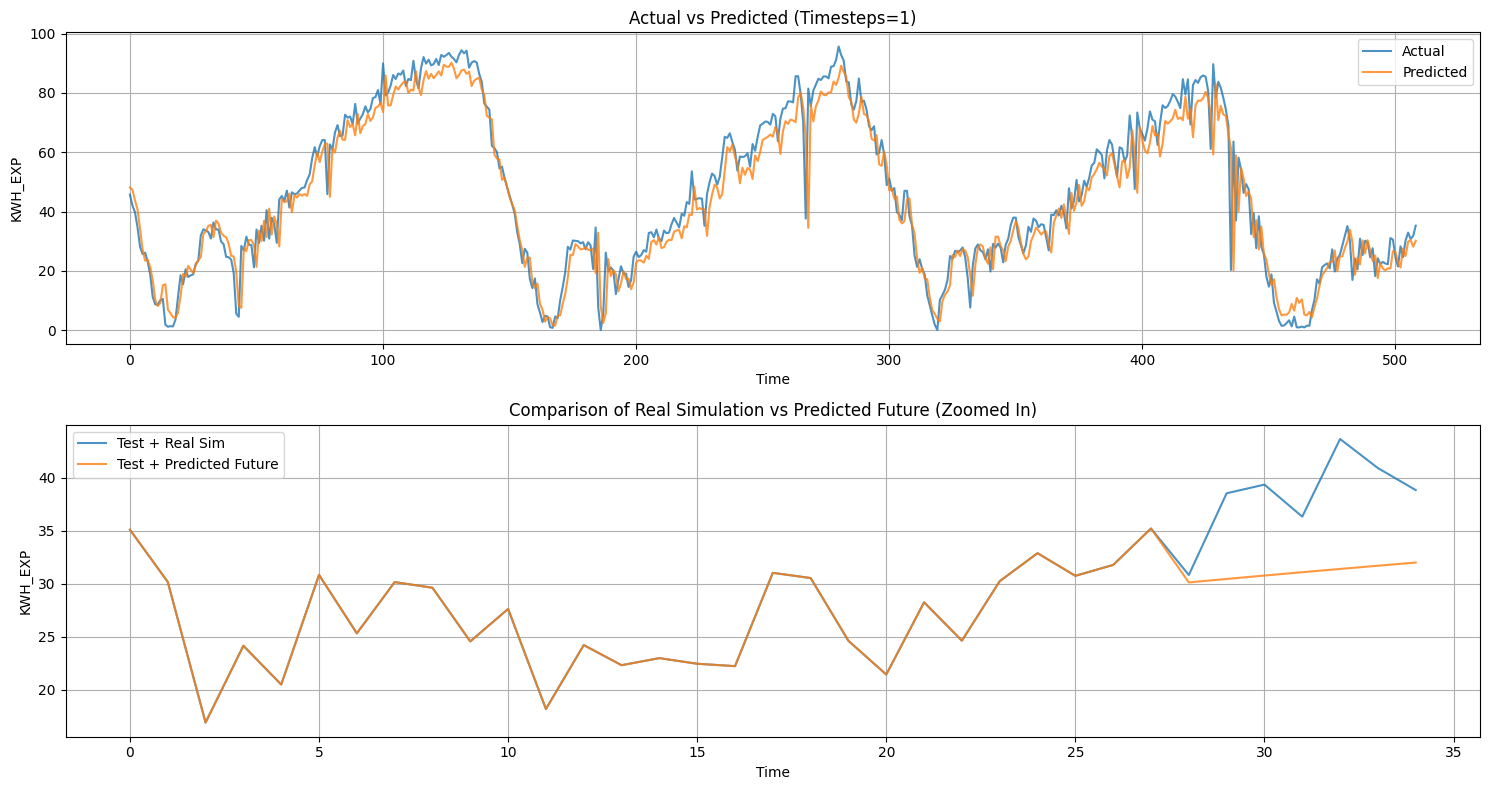


Metrics for timesteps=1:
MSE: 53.6594
R²: 0.9227
MAPE: 104045152405065.7344
MAE: 5.1979
Training time for timesteps = 1: 17.78 seconds

Training model with selected features and timesteps = 2
Epoch 21: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Results saved to bilstm_timestep_2_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


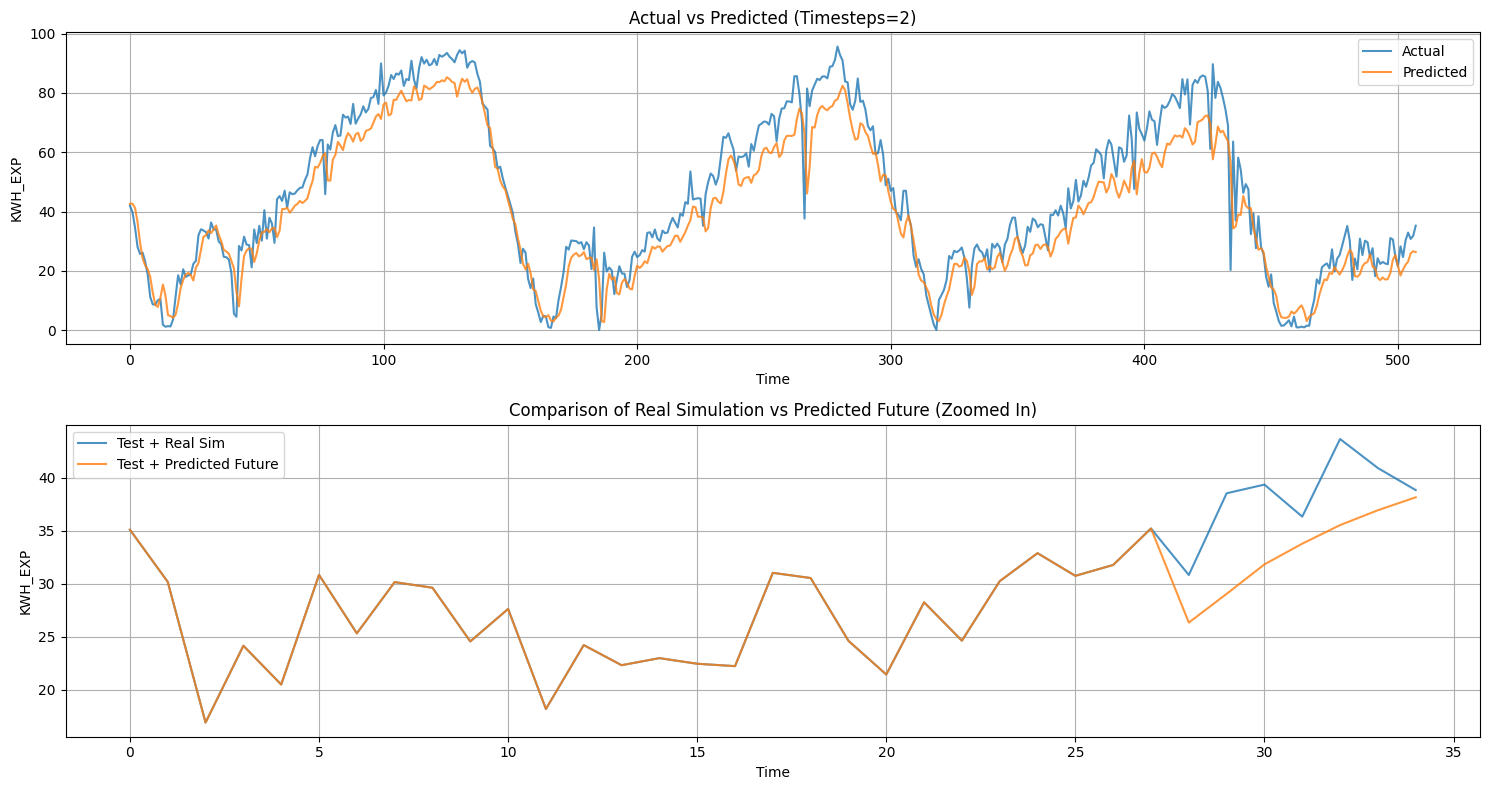


Metrics for timesteps=2:
MSE: 84.5077
R²: 0.8785
MAPE: 185286689992027.0312
MAE: 7.4135
Training time for timesteps = 2: 9.87 seconds

Training model with selected features and timesteps = 3
Epoch 17: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Results saved to bilstm_timestep_3_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


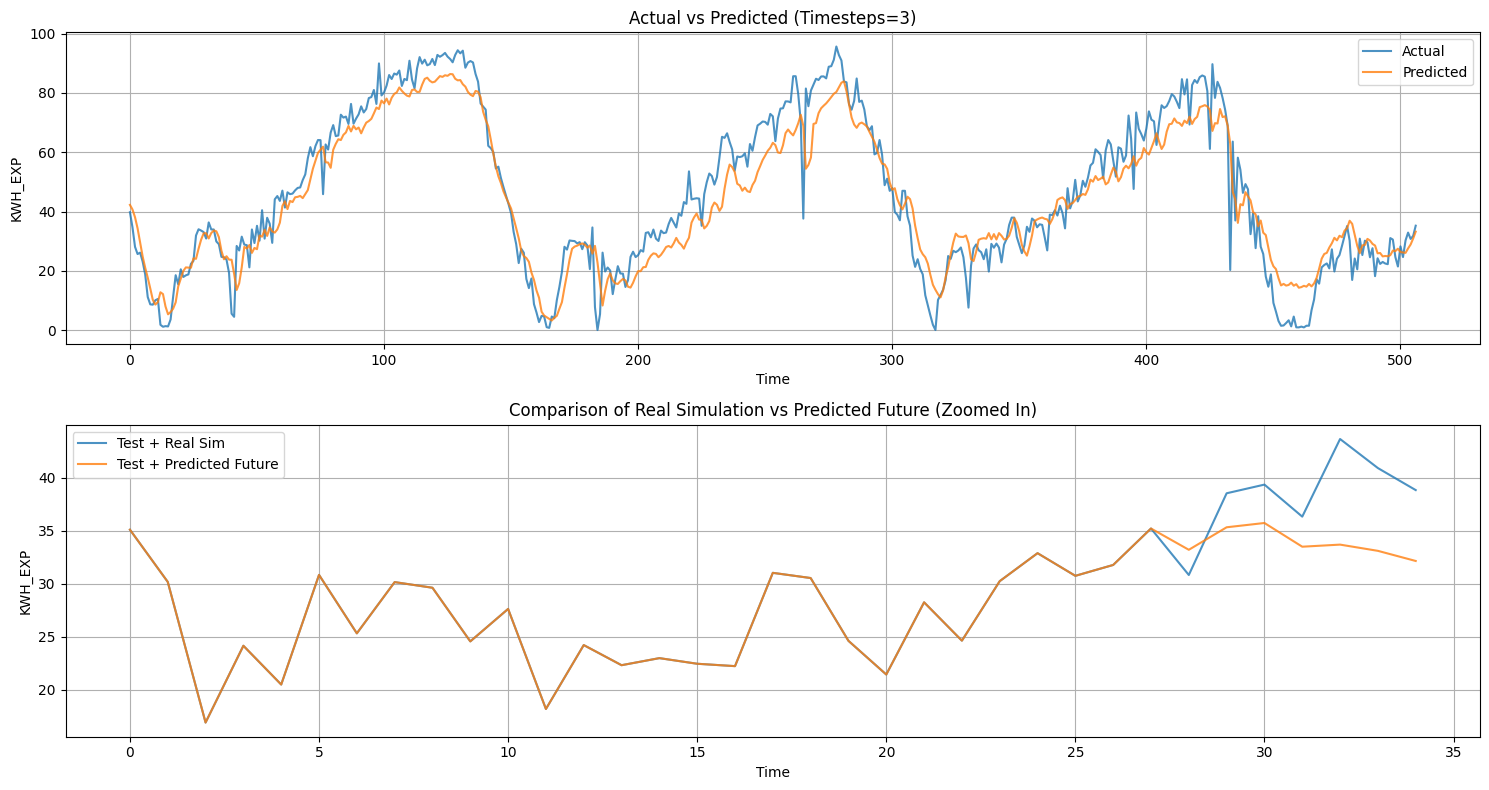


Metrics for timesteps=3:
MSE: 77.9740
R²: 0.8881
MAPE: 322898038701337.2500
MAE: 7.0200
Training time for timesteps = 3: 8.28 seconds

Training model with selected features and timesteps = 4
Epoch 14: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Results saved to bilstm_timestep_4_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


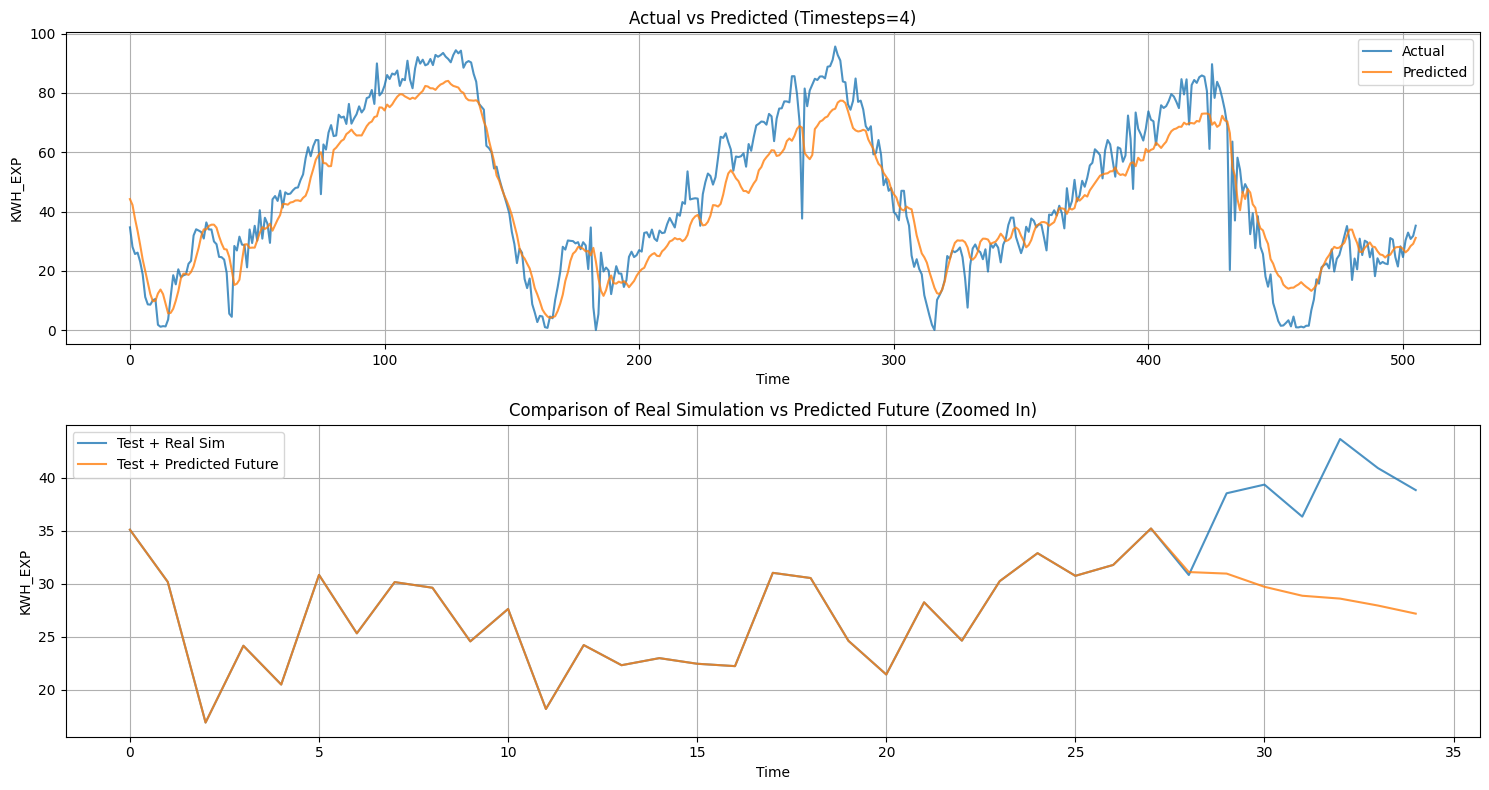


Metrics for timesteps=4:
MSE: 91.3917
R²: 0.8691
MAPE: 332661132220813.1875
MAE: 7.7918
Training time for timesteps = 4: 8.40 seconds

Training model with selected features and timesteps = 5
Epoch 12: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
Results saved to bilstm_timestep_5_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


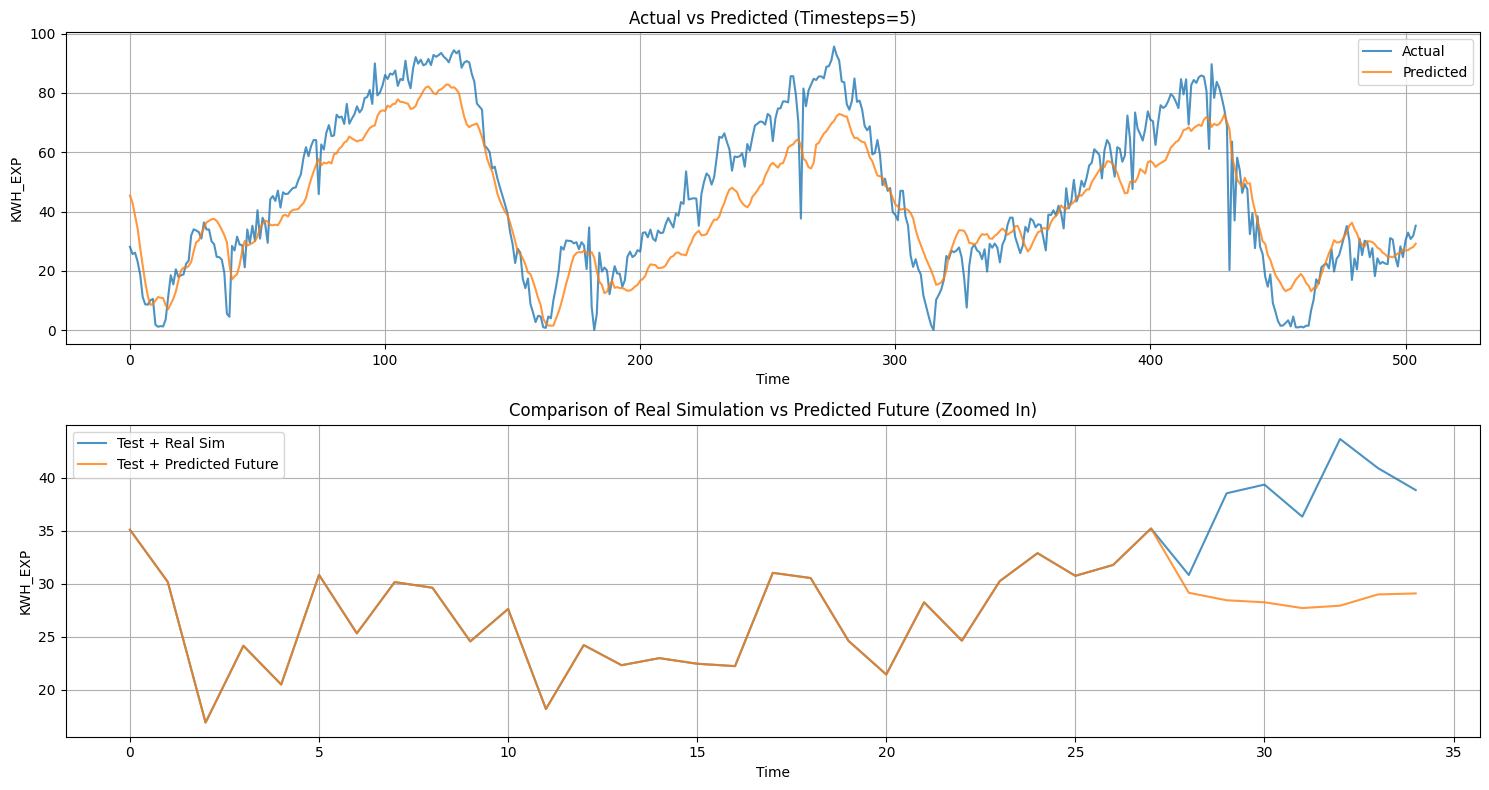


Metrics for timesteps=5:
MSE: 135.5909
R²: 0.8061
MAPE: 377697535925607.5625
MAE: 9.6267
Training time for timesteps = 5: 9.13 seconds

Training model with selected features and timesteps = 6
Epoch 14: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Results saved to bilstm_timestep_6_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


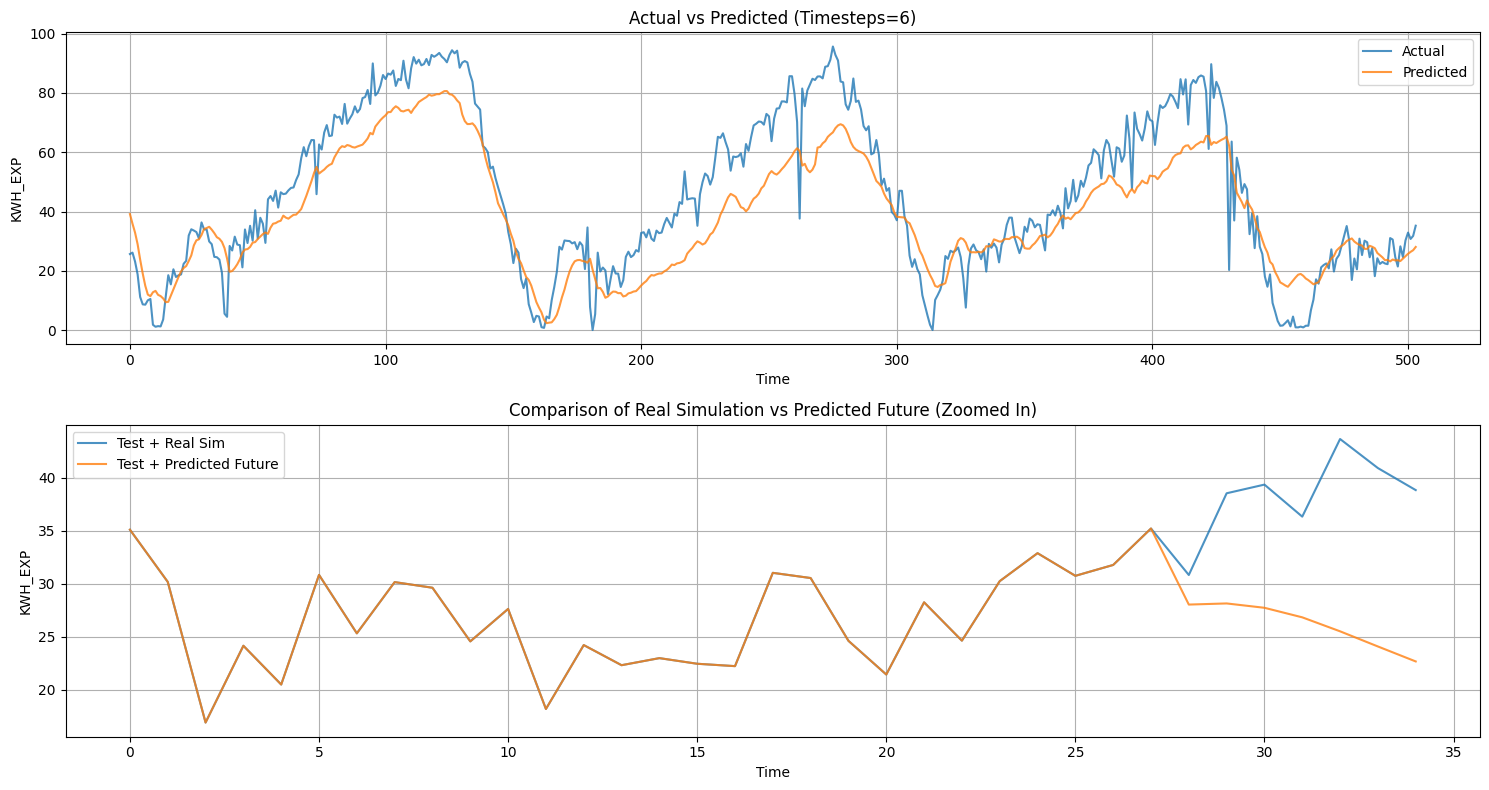


Metrics for timesteps=6:
MSE: 171.1491
R²: 0.7555
MAPE: 333314243449157.6875
MAE: 10.8577
Training time for timesteps = 6: 8.13 seconds

Training model with selected features and timesteps = 7
Epoch 9: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
Results saved to bilstm_timestep_7_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


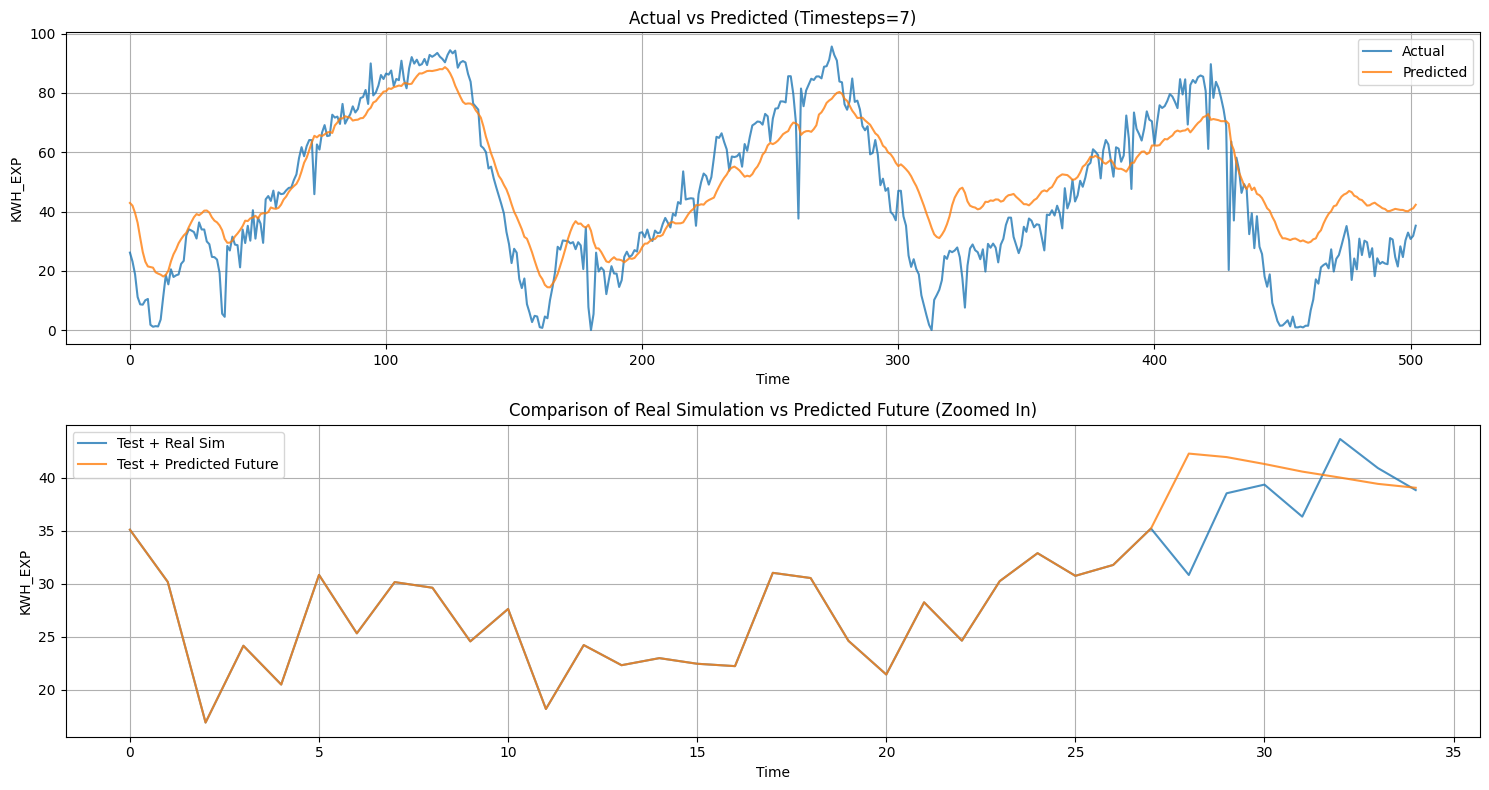


Metrics for timesteps=7:
MSE: 184.2923
R²: 0.7370
MAPE: 608423940042647.1250
MAE: 10.8042
Training time for timesteps = 7: 8.35 seconds
Total training execution time: 69.95 seconds


In [16]:
# Integrate with existing training scheme
total_training_start_time = time.time()
for ts in timesteps_list:

    print(f"\nTraining model with selected features and timesteps = {ts}")
    training_start_time = time.time()
    train_and_plot_bilstm(train_scaled_features, train_scaled_target.ravel(), test_scaled_features, test_scaled_target.ravel(), ts, real_sim)
    training_end_time = time.time()
    print(f"Training time for timesteps = {ts}: {training_end_time - training_start_time:.2f} seconds")

total_training_end_time = time.time()
print(f"Total training execution time: {total_training_end_time - total_training_start_time:.2f} seconds")

In [17]:
def train_and_plot_lstm(X_train, y_train, X_test, y_test, timesteps, real_sim):
    def create_dataset(X, y, time_steps=1):
      Xs, ys = [], []
      for i in range(len(X) - time_steps):
          v = X[i:(i + time_steps)]
          Xs.append(v)
          ys.append(y[i + time_steps])
      return np.array(Xs), np.array(ys)

    X_train_t, y_train_t = create_dataset(X_train, y_train, timesteps)
    X_test_t, y_test_t = create_dataset(X_test, y_test, timesteps)

    model = Sequential([
        Input(shape=(timesteps, X_train.shape[1])),
        LSTM(128, return_sequences=True),
        LSTM(64),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')

    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        mode='min',
        verbose=1
    )

    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=0.001,
        verbose=1
    )

    model.fit(
        X_train_t,
        y_train_t,
        validation_split=0.1,
        epochs=50,
        batch_size=512,
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )

    plot_predictions(model, X_test_t, y_test_t, target_scaler, timesteps, model_name="lstm", real_sim=real_sim, n_future=7)


In [18]:
# Daftar timestep yang akan diuji
timesteps_list = [1, 3, 3, 4, 5, 6, 7]


Training model with selected features and timesteps = 1
Epoch 29: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Results saved to lstm_timestep_1_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


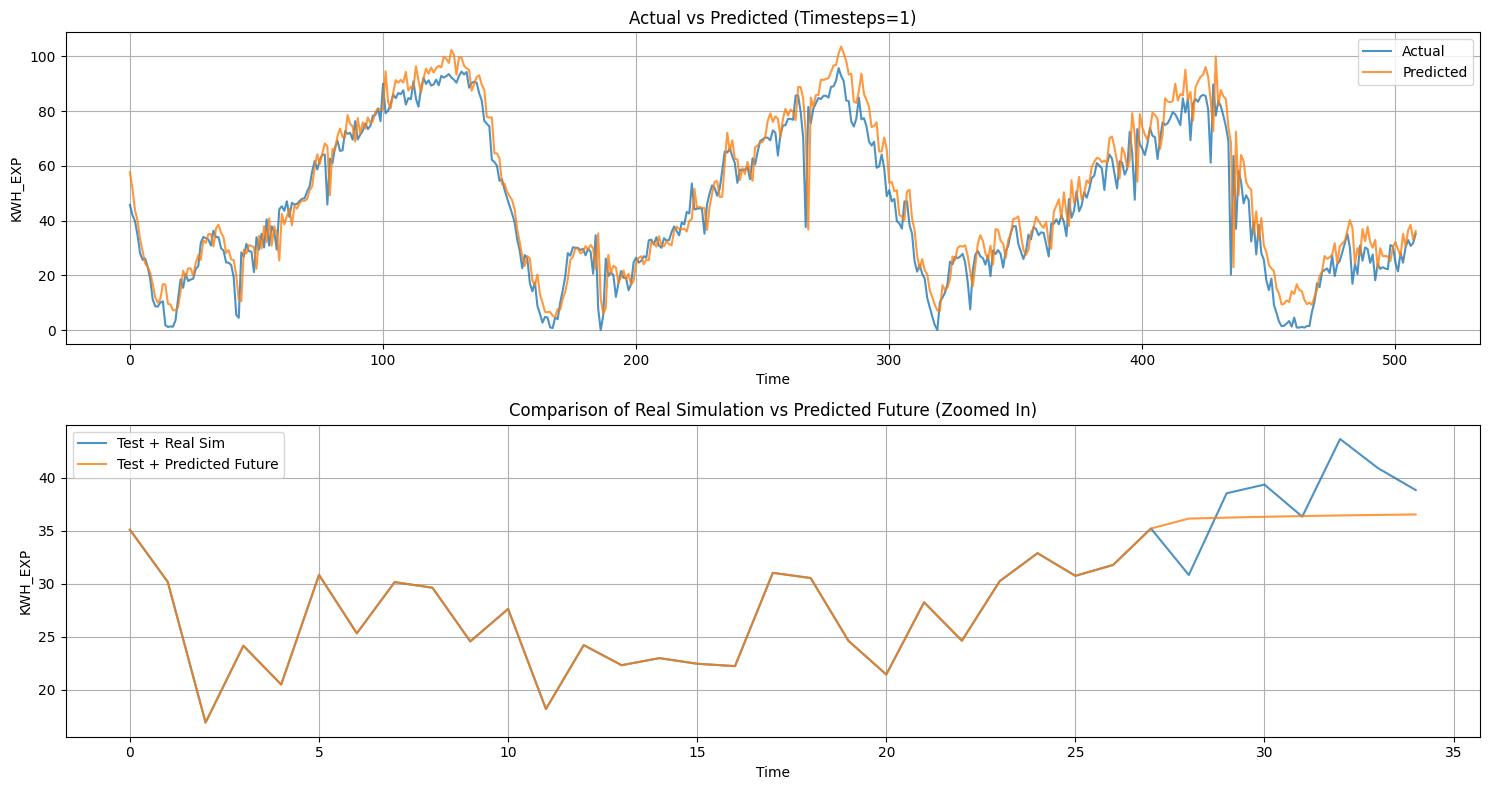


Metrics for timesteps=1:
MSE: 69.4940
R²: 0.8999
MAPE: 164363774366686.2812
MAE: 6.0901
Training time for timesteps = 1: 8.48 seconds

Training model with selected features and timesteps = 3
Epoch 20: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Results saved to lstm_timestep_3_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


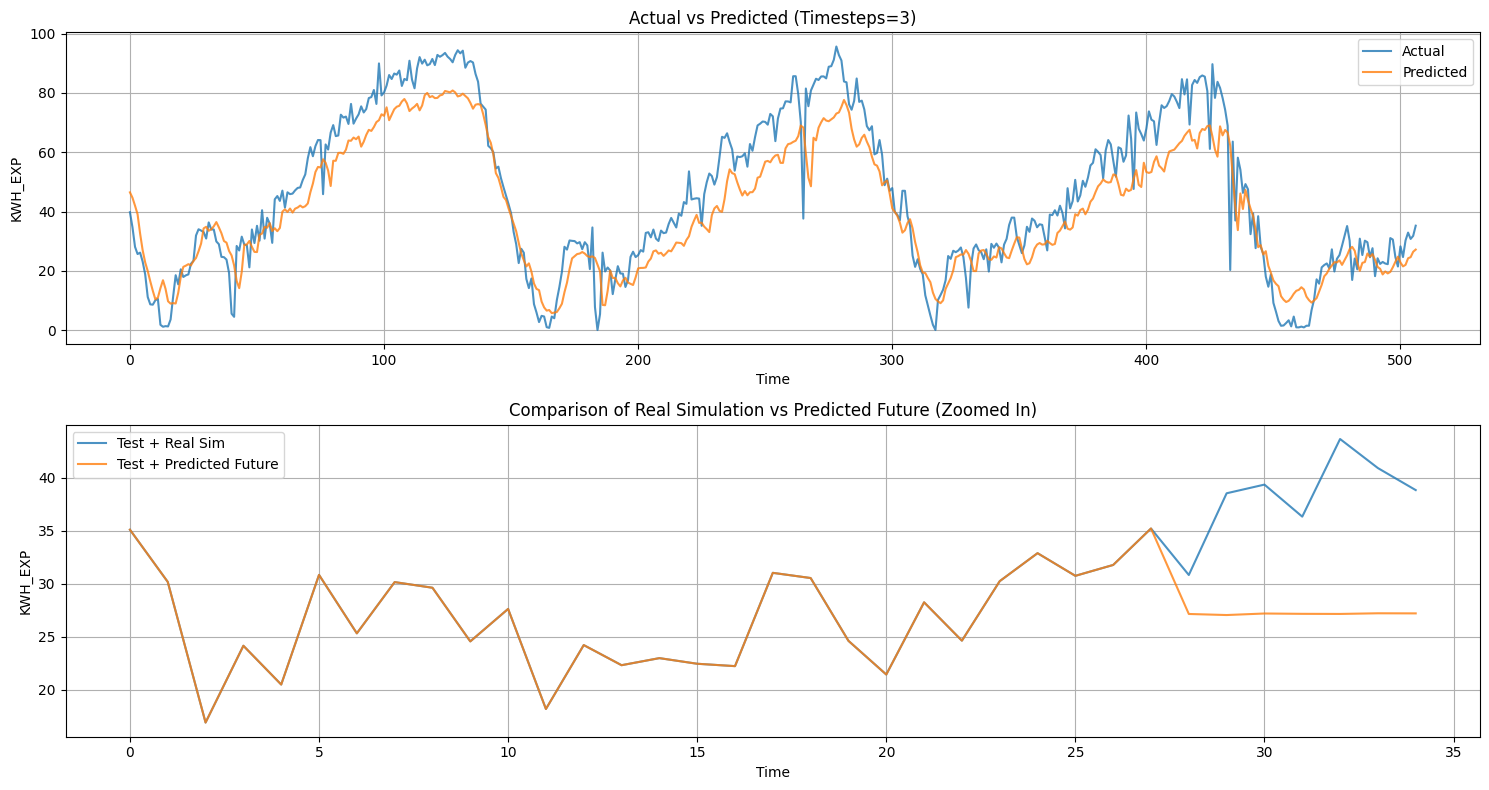


Metrics for timesteps=3:
MSE: 116.9763
R²: 0.8321
MAPE: 289440938115040.2500
MAE: 8.9203
Training time for timesteps = 3: 6.68 seconds

Training model with selected features and timesteps = 3
Epoch 20: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Results saved to lstm_timestep_3_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


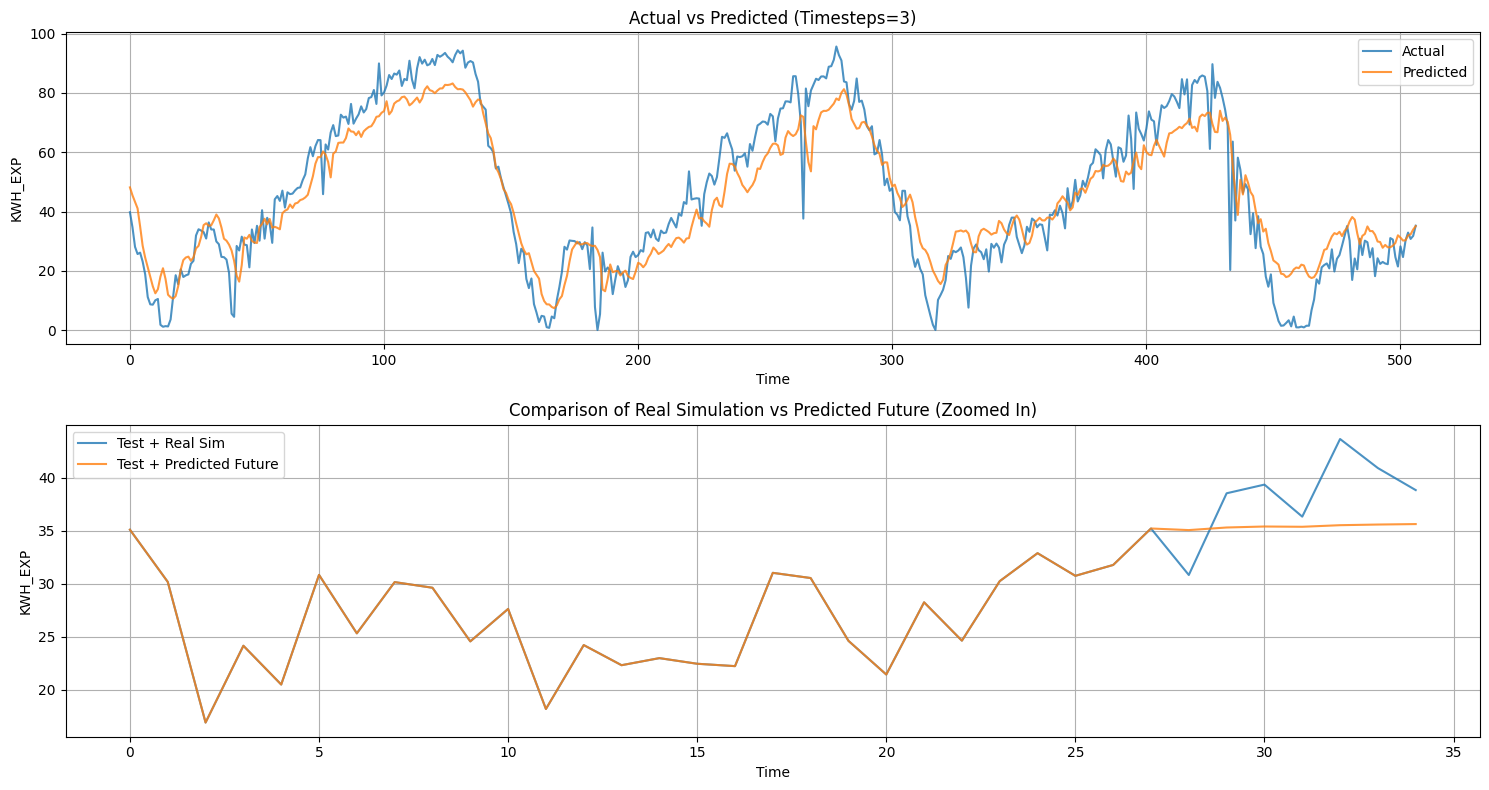


Metrics for timesteps=3:
MSE: 100.8200
R²: 0.8553
MAPE: 403770451547801.2500
MAE: 8.2171
Training time for timesteps = 3: 7.14 seconds

Training model with selected features and timesteps = 4
Epoch 18: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Results saved to lstm_timestep_4_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


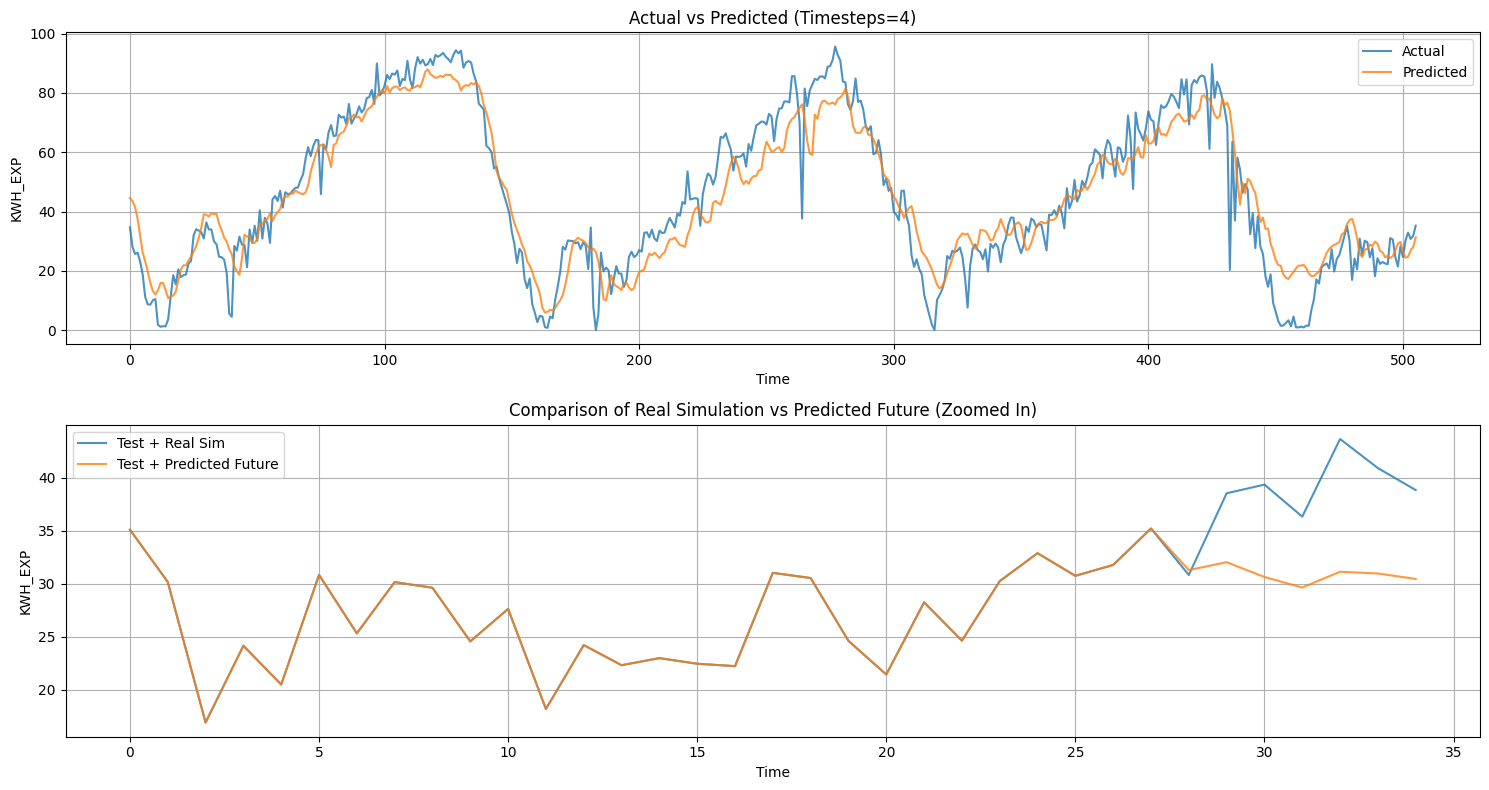


Metrics for timesteps=4:
MSE: 90.4116
R²: 0.8705
MAPE: 392380131512628.3125
MAE: 7.4619
Training time for timesteps = 4: 5.66 seconds

Training model with selected features and timesteps = 5
Epoch 17: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Results saved to lstm_timestep_5_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


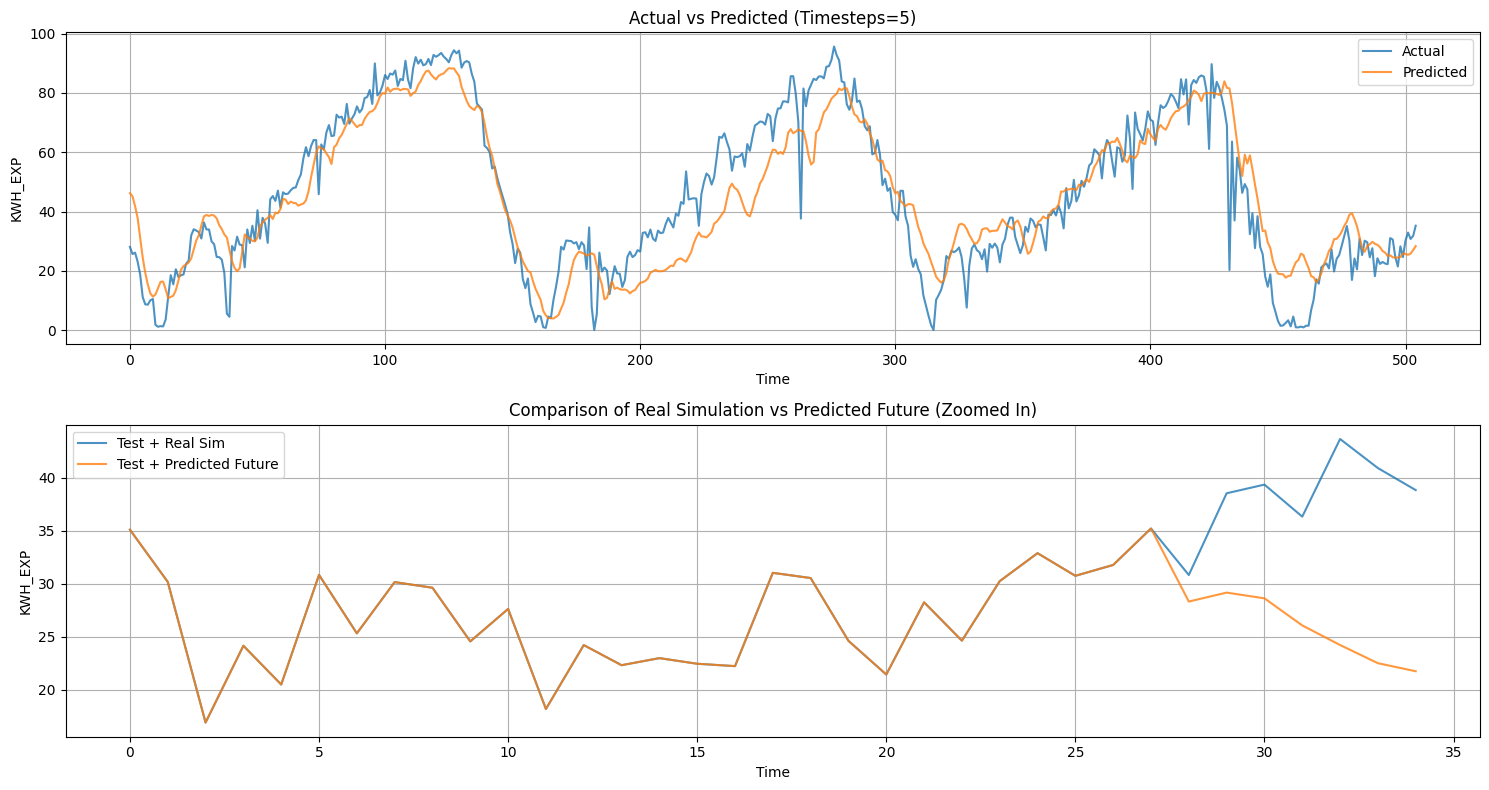


Metrics for timesteps=5:
MSE: 125.2069
R²: 0.8210
MAPE: 410546568450332.6250
MAE: 8.6842
Training time for timesteps = 5: 7.01 seconds

Training model with selected features and timesteps = 6
Epoch 21: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Results saved to lstm_timestep_6_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


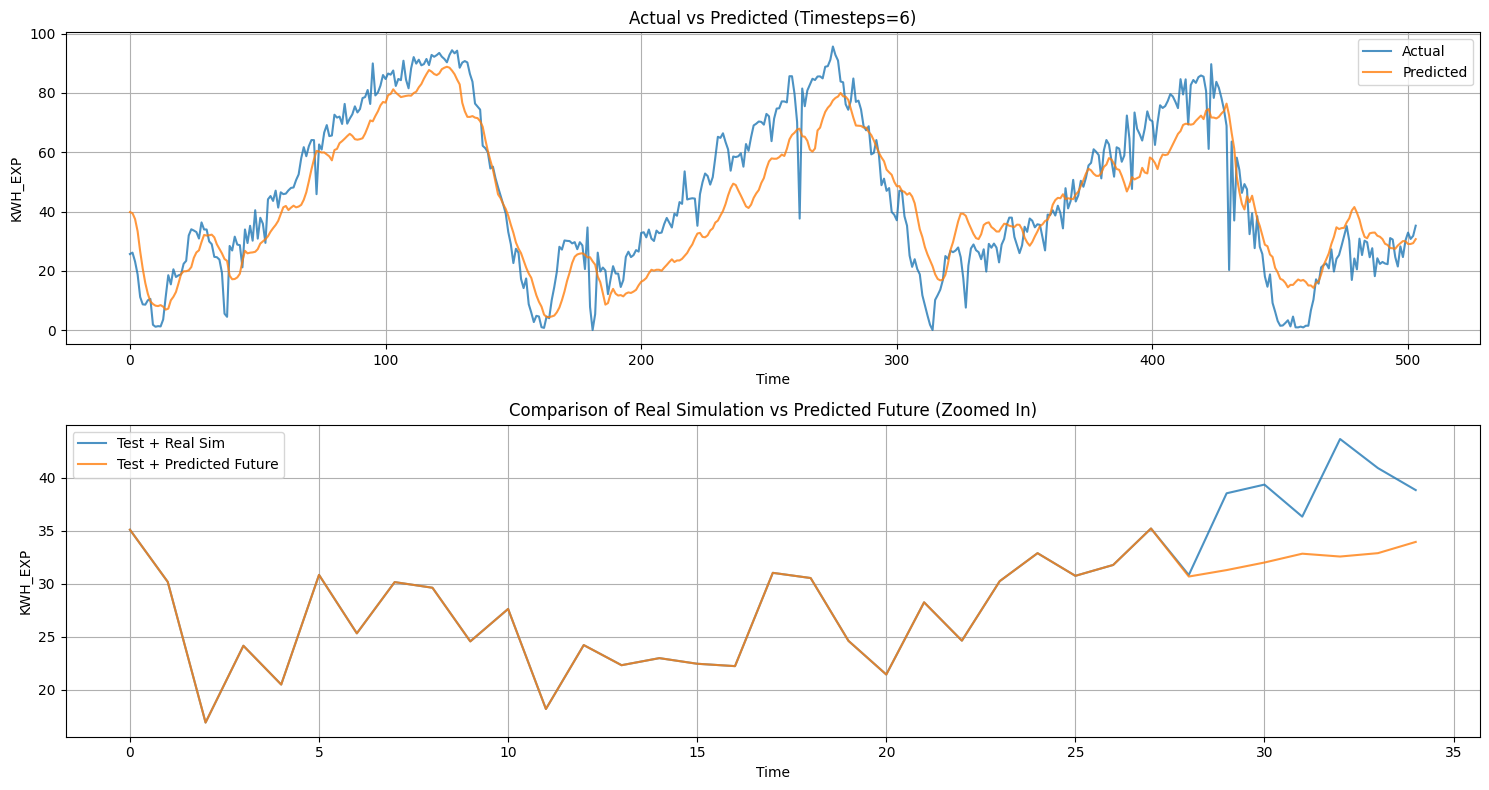


Metrics for timesteps=6:
MSE: 135.2218
R²: 0.8069
MAPE: 399464937741166.3125
MAE: 9.5637
Training time for timesteps = 6: 5.81 seconds

Training model with selected features and timesteps = 7
Epoch 13: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Results saved to lstm_timestep_7_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


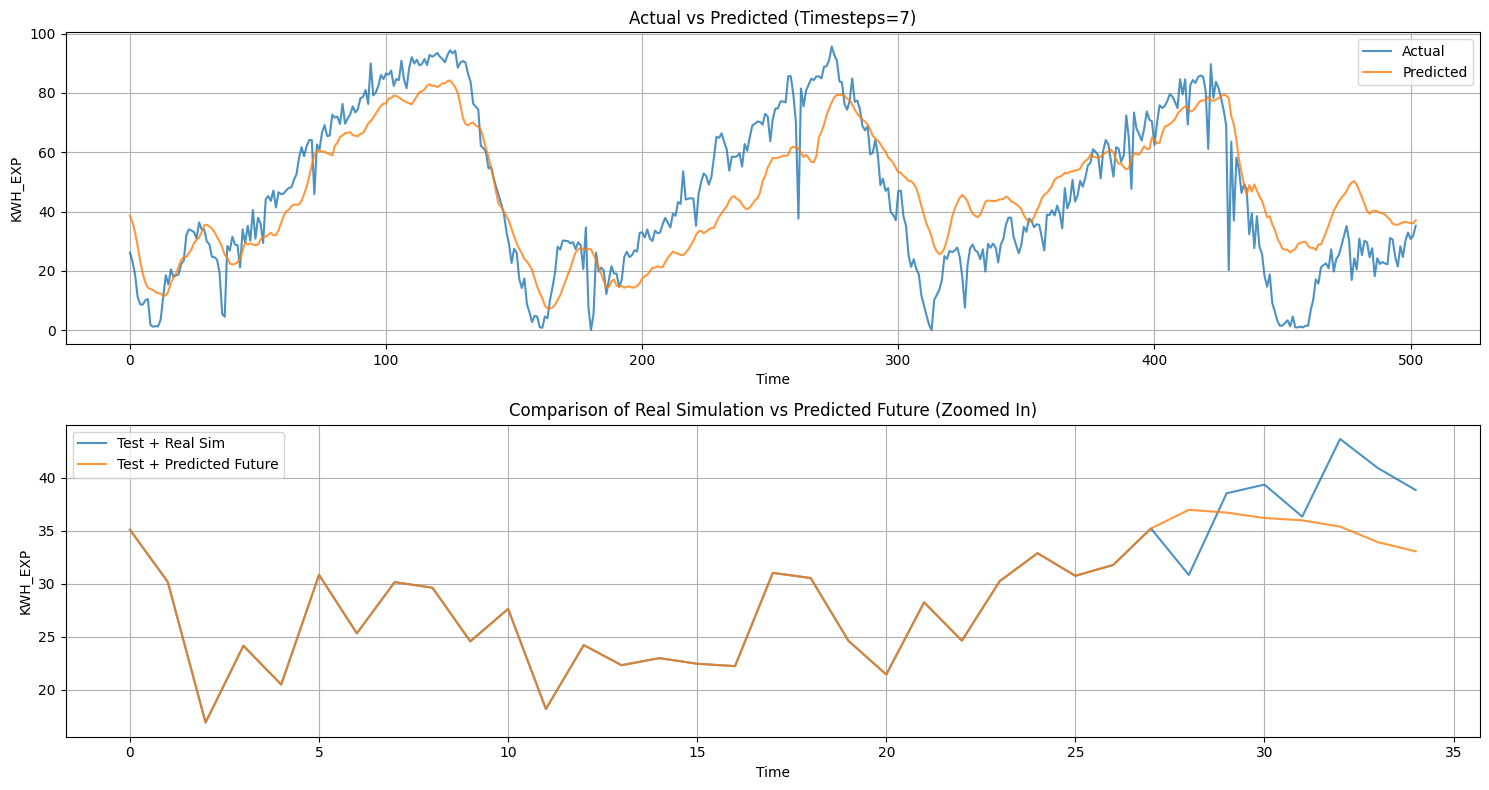


Metrics for timesteps=7:
MSE: 197.3994
R²: 0.7183
MAPE: 525018817396802.1875
MAE: 11.6693
Training time for timesteps = 7: 7.01 seconds
Total training execution time: 47.80 seconds


In [19]:
# Integrate with existing training scheme
total_training_start_time = time.time()
for ts in timesteps_list:
    print(f"\nTraining model with selected features and timesteps = {ts}")
    training_start_time = time.time()
    train_and_plot_lstm(train_scaled_features, train_scaled_target.ravel(), test_scaled_features, test_scaled_target.ravel(), ts, real_sim)
    training_end_time = time.time()
    print(f"Training time for timesteps = {ts}: {training_end_time - training_start_time:.2f} seconds")

total_training_end_time = time.time()
print(f"Total training execution time: {total_training_end_time - total_training_start_time:.2f} seconds")